# Network Intrusion Detection with Deep Learning

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2" #model will be trained on GPU 0
#from keras.utils import multi_gpu_model

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


## Open Data

In [ ]:
import numpy as np
def load_matrices(file_name):
    with open(file_name, 'rb') as f:
        A = np.load(f)
        B = np.load(f)
        C = np.load(f)
        D = np.load(f)
        E = np.load(f)
        F = np.load(f)
    return (A,B,C,D,E,F)


In [ ]:
my_file = '../data_NSL/data.npy'
train, test, test2, y_train, y_test, y_test2 = load_matrices(my_file)

## The Model

In [32]:
# talos item
import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live

# Keras items
from keras import backend as K
from keras.layers import Input, Dense 
from keras.layers import InputLayer
from keras.models import Model, Sequential
from keras.layers import Activation, Reshape, Dropout
from keras.optimizers import Adam
from keras.layers.embeddings import Embedding
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.activations import relu, elu
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import PReLU
from keras.callbacks import TensorBoard
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\chances\plots.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  Fi

In [34]:

def selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * elu(x, alpha)

#model.add(Dense(32, input_shape=(input_length - 1,)), activation=selu)

In [35]:
# then we load the dataset
x=train

input_dim = train.shape[1]
print(input_dim)

122


In [36]:
from keras.callbacks import ModelCheckpoint
filepath="./log3/taloslr_weights_a.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [37]:

filepath2="./log3/taloslr_weights_2a.best.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_acc', save_best_only=True, mode='max')
callbacks_list2 = [checkpoint2]

In [39]:
#actvation leakyrelu
LR= LeakyReLU(0.01)
LR.__name__ = 'lrelu'
#actvation prelu
#PR= PReLU()
#PR.__name__ = 'prelu'

In [40]:
# first we have to make sure to input data and params into the function
# add input parameters to the function
def dnn(x_train, y_train, x_val, y_val, params):

    input_dim = x_train.shape[1]

    input_img = Input(shape=(input_dim,))

    first_neuron=params['first_neuron']
    second_neuron=params['second_neuron']
    third_neuron=params['third_neuron']
    fourth_neuron=params['fourth_neuron']
    batch_size=params['batch_size']
    kernel_initial=params['kernel_initializer']
    lr=params['lr']
    activation=params['activation']
    
    print('activation=',activation)

    ###AE
    
    # replace the hyperparameter inputs with references to params dictionary 
    autoencoder = Sequential()
    #encoder
    
    if activation==PReLU: 
        autoencoder.add(Dense(first_neuron, input_shape=(input_dim,), kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(second_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(third_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(fourth_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
                   
        #decoder
        #model.add(Dense(8, activation=params['activation']))
        autoencoder.add(Dense(third_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(second_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(first_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(input_dim, activation='sigmoid', kernel_initializer=kernel_initial))
        
    else:
        autoencoder.add(Dense(first_neuron, input_shape=(input_dim,), activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(second_neuron, activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(third_neuron, activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(fourth_neuron, activation=activation, kernel_initializer=kernel_initial))
        #decoder
        #model.add(Dense(8, activation=params['activation']))
        autoencoder.add(Dense(third_neuron, activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(second_neuron, activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(first_neuron, activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(input_dim, activation='sigmoid', kernel_initializer=kernel_initial))
    
     #model = multi_gpu_model(model, gpus=1)

    
    #model = multi_gpu_model(model, gpus=1)
    autoencoder.summary()
    print(input_dim)

    input_img = Input(shape=(input_dim,))
    encoder_layer1 = autoencoder.layers[0]
    encoder_layer2 = autoencoder.layers[1]
    encoder_layer3 = autoencoder.layers[2]
    encoder_layer4 = autoencoder.layers[3]
    encoder = Model(input_img, encoder_layer4(encoder_layer3(encoder_layer2(encoder_layer1(input_img)))))
    
    #encoder_layer1 = autoencoder.layers[0]
    #encoder_layer2 = autoencoder.layers[1]
    #encoder_layer3 = autoencoder.layers[2]
    #encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))
    encoder.summary()

    ## using binary cross entropy because from 122 features only 32 features (sudah dinormalisasi dalam rentang 0 dan 1) float and 90 features binary
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    #model.compile(loss=params['losses'],
    #              optimizer=params['optimizer'](),
    #              metrics=['acc', fmeasure_acc])
    
   

    
    history=autoencoder.fit(x,x,
                             epochs=params['epochs'],
                             batch_size=batch_size,
                              #shuffle=True,
                              #validation_split=0.2,
                              callbacks=callbacks_list,                    
                             #callbacks=[early_stopping])
                              validation_data=(test,test),
                              verbose=0)

    num_classes=5
    out2 = Dense(num_classes, activation='softmax',kernel_initializer=kernel_initial)(encoder.output)
    newmodel = Model(encoder.input,out2)
    
   
    newmodel.compile(loss='categorical_crossentropy', 
                     #optimizer='adam', 
                     optimizer= Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0, amsgrad=False),
                     metrics=['acc']) 
    newmodel.summary()


    history2a=newmodel.fit(x, y,
                           epochs=params['epochs2'],
                           batch_size=batch_size,
                           #validation_split=0.2,
                           callbacks=callbacks_list2,
                           #callbacks=[early_stopping],
                           validation_data=(test,y_test),
                           verbose=0)

    
    del encoder
    del autoencoder
    #del dnn_model
    
    tf.reset_default_graph()
    
    return history2a, newmodel #, encoder
    

In [42]:
# then we can go ahead and set the parameter space
p = {'first_neuron':[100, 90,80, 75],
     'second_neuron':[60, 50],
     'third_neuron':[40,30],
     'forth_neuron': [20,15],
     'batch_size': [32,64,256],
     'epochs': [30],
     'epochs2': [50],
     'dropout': [0],
     'kernel_initializer': ['lecun_uniform','lecun_normal','he_normal','he_uniform','normal','glorot_uniform','glorot_normal'],
     'optimizer': [Adam],
     'lr':[0.1,0.01, 0.001,0.0001,0.00001],
     #'activation':[relu, elu,selu]}
     'activation':[relu, elu,selu, LR,PReLU]}

In [43]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras


    

In [44]:

t = ta.Scan(x, y, p, dnn, experiment_no='10',   
            grid_downsample=0.05,)

#experiment no 6 3780 kombinasi

  0%|          | 0/403 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dens

  0%|          | 1/403 [04:47<32:08:20, 287.81s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

  0%|          | 2/403 [08:39<30:10:35, 270.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

  1%|          | 3/403 [36:59<77:44:36, 699.69s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

  1%|          | 4/403 [50:13<80:41:45, 728.08s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

  1%|          | 5/403 [1:16:03<107:45:25, 974.69s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

  1%|▏         | 6/403 [1:29:20<101:36:20, 921.36s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

  2%|▏         | 7/403 [1:44:02<100:02:04, 909.41s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

  2%|▏         | 8/403 [1:57:16<95:59:47, 874.90s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

  2%|▏         | 9/403 [2:01:03<74:27:32, 680.34s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

  2%|▏         | 10/403 [2:04:52<59:30:06, 545.06s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

  3%|▎         | 11/403 [2:09:01<49:41:27, 456.35s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

  3%|▎         | 12/403 [2:12:57<42:22:32, 390.16s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

  3%|▎         | 13/403 [2:38:38<79:39:45, 735.35s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

  3%|▎         | 14/403 [3:04:21<105:38:53, 977.72s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

  4%|▎         | 15/403 [3:32:35<128:31:24, 1192.49s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

  4%|▍         | 16/403 [3:36:46<97:50:59, 910.23s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

  4%|▍         | 17/403 [3:40:36<75:42:23, 706.07s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

  4%|▍         | 18/403 [4:08:56<107:24:44, 1004.37s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

  5%|▍         | 19/403 [4:22:11<100:24:24, 941.31s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

  5%|▍         | 20/403 [4:26:03<77:30:23, 728.52s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

  5%|▌         | 21/403 [4:39:21<79:31:14, 749.41s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

  5%|▌         | 22/403 [5:07:26<109:02:03, 1030.25s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

  6%|▌         | 23/403 [5:32:56<124:34:21, 1180.16s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

  6%|▌         | 24/403 [5:47:32<114:38:26, 1088.93s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

  6%|▌         | 25/403 [5:51:21<87:13:37, 830.73s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

  6%|▋         | 26/403 [6:17:15<109:43:21, 1047.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

  7%|▋         | 27/403 [6:21:26<84:28:43, 808.84s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

  7%|▋         | 28/403 [6:36:09<86:33:41, 830.99s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

  7%|▋         | 29/403 [7:02:02<108:49:48, 1047.56s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

  7%|▋         | 30/403 [7:30:10<128:27:59, 1239.89s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

  8%|▊         | 31/403 [7:58:30<142:22:12, 1377.78s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

  8%|▊         | 32/403 [8:02:22<106:34:32, 1034.16s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

  8%|▊         | 33/403 [8:28:04<121:56:34, 1186.47s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

  8%|▊         | 34/403 [8:53:50<132:39:50, 1294.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

  9%|▊         | 35/403 [8:57:44<99:46:48, 976.11s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

  9%|▉         | 36/403 [9:26:08<121:46:32, 1194.53s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

  9%|▉         | 37/403 [9:39:31<109:29:34, 1076.98s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

  9%|▉         | 38/403 [10:07:50<128:08:15, 1263.82s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 10%|▉         | 39/403 [10:36:04<140:49:03, 1392.70s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 10%|▉         | 40/403 [12:15:59<279:40:14, 2773.59s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 10%|█         | 41/403 [12:40:13<239:04:34, 2377.55s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 10%|█         | 42/403 [12:54:48<193:13:17, 1926.86s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 11%|█         | 43/403 [13:08:06<158:48:10, 1588.03s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 11%|█         | 44/403 [13:22:52<137:22:18, 1377.54s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 11%|█         | 45/403 [13:36:13<119:46:42, 1204.48s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 11%|█▏        | 46/403 [13:49:36<107:31:22, 1084.26s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 12%|█▏        | 47/403 [13:53:26<81:52:53, 828.02s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 12%|█▏        | 48/403 [13:57:17<63:57:51, 648.65s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 12%|█▏        | 49/403 [14:10:39<68:19:44, 694.87s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 12%|█▏        | 50/403 [14:14:33<54:34:43, 556.61s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 13%|█▎        | 51/403 [14:40:20<83:28:39, 853.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 13%|█▎        | 52/403 [14:53:44<81:45:49, 838.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 13%|█▎        | 53/403 [15:07:05<80:27:26, 827.56s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 13%|█▎        | 54/403 [15:20:20<79:16:37, 817.76s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 14%|█▎        | 55/403 [18:19:16<366:40:51, 3793.25s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 14%|█▍        | 56/403 [18:23:07<262:35:41, 2724.33s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 14%|█▍        | 57/403 [18:48:59<228:02:32, 2372.69s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 14%|█▍        | 58/403 [18:53:10<166:23:04, 1736.19s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 15%|█▍        | 59/403 [18:57:22<123:22:24, 1291.12s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 15%|█▍        | 60/403 [19:12:01<111:12:38, 1167.23s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 15%|█▌        | 61/403 [19:15:51<84:11:57, 886.31s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 15%|█▌        | 62/403 [19:29:11<81:29:32, 860.33s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 16%|█▌        | 63/403 [19:43:46<81:40:26, 864.78s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 16%|█▌        | 64/403 [19:57:02<79:29:42, 844.20s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 16%|█▌        | 65/403 [20:10:26<78:07:33, 832.11s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 16%|█▋        | 66/403 [20:23:43<76:54:26, 821.56s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 17%|█▋        | 67/403 [20:27:35<60:10:29, 644.73s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 17%|█▋        | 68/403 [20:55:49<89:15:53, 959.26s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 17%|█▋        | 69/403 [20:59:59<69:15:26, 746.49s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 17%|█▋        | 70/403 [21:03:48<54:42:18, 591.41s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 18%|█▊        | 71/403 [21:08:01<45:09:48, 489.73s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 18%|█▊        | 72/403 [21:11:53<37:55:40, 412.51s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 18%|█▊        | 73/403 [21:37:42<69:04:12, 753.49s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 18%|█▊        | 74/403 [21:52:19<72:15:12, 790.62s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 19%|█▊        | 75/403 [22:18:04<92:39:14, 1016.94s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 19%|█▉        | 76/403 [22:32:44<88:37:20, 975.66s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 19%|█▉        | 77/403 [23:01:01<107:57:02, 1192.09s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 19%|█▉        | 78/403 [23:14:19<96:56:21, 1073.79s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 20%|█▉        | 79/403 [23:18:33<74:31:54, 828.13s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 20%|█▉        | 80/403 [23:22:25<58:14:53, 649.21s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 20%|██        | 81/403 [23:26:16<46:49:59, 523.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 20%|██        | 82/403 [23:39:31<53:56:43, 604.99s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 21%|██        | 83/403 [24:07:56<83:07:55, 935.24s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 21%|██        | 84/403 [24:22:36<81:23:12, 918.47s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 21%|██        | 85/403 [24:48:27<97:54:15, 1108.35s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 21%|██▏       | 86/403 [25:01:50<89:31:04, 1016.61s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 22%|██▏       | 87/403 [25:15:10<83:32:25, 951.73s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 22%|██▏       | 88/403 [25:40:56<98:52:24, 1129.98s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 22%|██▏       | 89/403 [25:54:18<89:57:56, 1031.45s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 22%|██▏       | 90/403 [26:07:33<83:31:33, 960.68s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 23%|██▎       | 91/403 [26:33:27<98:40:20, 1138.53s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 23%|██▎       | 92/403 [26:59:10<108:51:25, 1260.08s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 23%|██▎       | 93/403 [27:25:01<116:00:55, 1347.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 23%|██▎       | 94/403 [27:38:23<101:36:20, 1183.76s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 24%|██▎       | 95/403 [27:42:13<76:46:56, 897.46s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 24%|██▍       | 96/403 [28:07:59<93:08:03, 1092.13s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 24%|██▍       | 97/403 [28:36:12<108:09:41, 1272.49s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 24%|██▍       | 98/403 [28:49:32<95:46:43, 1130.50s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 25%|██▍       | 99/403 [29:15:13<105:52:52, 1253.86s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 25%|██▍       | 100/403 [29:41:04<113:02:10, 1343.00s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 25%|██▌       | 101/403 [29:54:29<99:06:54, 1181.50s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 25%|██▌       | 102/403 [30:20:07<107:43:24, 1288.39s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 26%|██▌       | 103/403 [30:23:57<80:54:43, 970.94s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 26%|██▌       | 104/403 [30:37:18<76:24:47, 920.03s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 26%|██▌       | 105/403 [30:51:53<75:02:30, 906.54s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 26%|██▋       | 106/403 [31:17:38<90:35:07, 1098.00s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 27%|██▋       | 107/403 [31:43:35<101:35:49, 1235.64s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 27%|██▋       | 108/403 [32:09:25<108:59:47, 1330.13s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 27%|██▋       | 109/403 [32:22:55<95:52:05, 1173.90s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 27%|██▋       | 110/403 [32:26:45<72:30:00, 890.79s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 28%|██▊       | 111/403 [32:41:22<71:55:41, 886.79s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 28%|██▊       | 112/403 [32:45:14<55:47:13, 690.15s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 28%|██▊       | 113/403 [32:59:50<60:05:15, 745.92s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 28%|██▊       | 114/403 [33:03:42<47:30:12, 591.74s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 29%|██▊       | 115/403 [33:17:15<52:38:52, 658.10s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 29%|██▉       | 116/403 [33:31:51<57:40:43, 723.50s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 29%|██▉       | 117/403 [33:46:24<61:02:24, 768.34s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 29%|██▉       | 118/403 [33:50:16<48:05:57, 607.57s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 30%|██▉       | 119/403 [34:15:56<69:58:56, 887.10s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 30%|██▉       | 120/403 [34:19:51<54:21:44, 691.54s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 30%|███       | 121/403 [34:45:44<74:25:30, 950.11s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 30%|███       | 122/403 [34:49:36<57:20:50, 734.70s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 31%|███       | 123/403 [35:15:30<76:15:16, 980.42s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 31%|███       | 124/403 [35:19:47<59:09:23, 763.31s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 31%|███       | 125/403 [35:34:23<61:33:38, 797.19s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 31%|███▏      | 126/403 [35:38:15<48:17:41, 627.66s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 32%|███▏      | 127/403 [35:42:28<39:29:30, 515.11s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 32%|███▏      | 128/403 [36:10:58<66:44:39, 873.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 32%|███▏      | 129/403 [36:15:14<52:23:27, 688.35s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 32%|███▏      | 130/403 [36:41:13<72:00:09, 949.48s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 33%|███▎      | 131/403 [37:07:08<85:27:44, 1131.12s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 33%|███▎      | 132/403 [37:32:55<94:32:28, 1255.90s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 33%|███▎      | 133/403 [38:01:17<104:14:47, 1389.95s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 33%|███▎      | 134/403 [38:16:02<92:31:20, 1238.22s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 33%|███▎      | 135/403 [38:29:23<82:24:53, 1107.07s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 34%|███▎      | 136/403 [38:55:29<92:19:50, 1244.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 34%|███▍      | 137/403 [38:59:22<69:33:20, 941.35s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 34%|███▍      | 138/403 [39:03:15<53:38:14, 728.66s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 34%|███▍      | 139/403 [45:59:30<586:52:19, 8002.80s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 35%|███▍      | 140/403 [46:03:24<414:22:40, 5672.09s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 35%|███▍      | 141/403 [46:07:35<294:26:52, 4045.85s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 35%|███▌      | 142/403 [46:21:01<222:50:42, 3073.73s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 35%|███▌      | 143/403 [46:24:52<160:24:29, 2221.04s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 36%|███▌      | 144/403 [46:50:52<145:31:12, 2022.68s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 36%|███▌      | 145/403 [46:55:03<106:52:20, 1491.24s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 36%|███▌      | 146/403 [46:58:56<79:29:28, 1113.50s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 36%|███▋      | 147/403 [47:12:18<72:32:22, 1020.09s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 37%|███▋      | 148/403 [47:16:09<55:29:45, 783.47s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 37%|███▋      | 149/403 [47:20:19<43:58:37, 623.30s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 37%|███▋      | 150/403 [47:34:55<49:08:27, 699.24s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 37%|███▋      | 151/403 [47:48:17<51:06:06, 730.03s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 38%|███▊      | 152/403 [48:14:08<68:04:35, 976.40s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 38%|███▊      | 153/403 [48:27:46<64:30:35, 928.94s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 38%|███▊      | 154/403 [48:31:58<50:11:41, 725.71s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 38%|███▊      | 155/403 [48:45:18<51:31:43, 748.00s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 39%|███▊      | 156/403 [48:59:48<53:50:26, 784.72s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 39%|███▉      | 157/403 [49:13:04<53:51:29, 788.17s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 39%|███▉      | 158/403 [49:27:46<55:33:17, 816.32s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 39%|███▉      | 159/403 [49:53:37<70:15:20, 1036.56s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 40%|███▉      | 160/403 [50:19:06<79:56:57, 1184.43s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 40%|███▉      | 161/403 [50:32:20<71:44:38, 1067.27s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 40%|████      | 162/403 [50:36:31<55:02:24, 822.17s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 40%|████      | 163/403 [51:04:53<72:25:05, 1086.27s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 41%|████      | 164/403 [51:18:18<66:30:30, 1001.80s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 41%|████      | 165/403 [51:22:09<50:56:41, 770.59s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 41%|████      | 166/403 [51:47:57<66:05:20, 1003.88s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 41%|████▏     | 167/403 [52:02:40<63:26:10, 967.67s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 42%|████▏     | 168/403 [52:06:56<49:13:01, 753.96s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 42%|████▏     | 169/403 [52:35:12<67:22:49, 1036.62s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 42%|████▏     | 170/403 [52:49:43<63:53:15, 987.11s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 42%|████▏     | 171/403 [52:53:37<49:02:50, 761.08s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 43%|████▎     | 172/403 [53:06:58<49:36:45, 773.18s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 43%|████▎     | 173/403 [53:35:20<67:11:07, 1051.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 43%|████▎     | 174/403 [54:01:22<76:38:24, 1204.82s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 43%|████▎     | 175/403 [54:27:08<82:47:08, 1307.14s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 44%|████▎     | 176/403 [54:31:23<62:31:11, 991.50s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 44%|████▍     | 177/403 [54:57:11<72:43:15, 1158.39s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 44%|████▍     | 178/403 [55:25:36<82:39:20, 1322.49s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 44%|████▍     | 179/403 [55:29:33<62:00:58, 996.69s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 45%|████▍     | 180/403 [55:43:07<58:21:08, 942.01s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 45%|████▍     | 181/403 [56:09:09<69:33:58, 1128.10s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 45%|████▌     | 182/403 [56:22:39<63:23:15, 1032.56s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 45%|████▌     | 183/403 [56:51:05<75:26:36, 1234.53s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 46%|████▌     | 184/403 [57:04:28<67:14:17, 1105.29s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 46%|████▌     | 185/403 [57:08:21<51:04:29, 843.44s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 46%|████▌     | 186/403 [57:12:16<39:50:08, 660.87s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 46%|████▋     | 187/403 [57:16:08<31:55:49, 532.17s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 47%|████▋     | 188/403 [57:42:05<50:09:16, 839.80s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 47%|████▋     | 189/403 [57:45:55<39:02:11, 656.69s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 47%|████▋     | 190/403 [57:59:19<41:28:23, 700.96s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 47%|████▋     | 191/403 [58:03:11<32:59:28, 560.23s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 48%|████▊     | 192/403 [58:17:54<38:30:31, 657.02s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 48%|████▊     | 193/403 [58:21:48<30:55:50, 530.24s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 48%|████▊     | 194/403 [58:50:03<51:03:41, 879.53s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 48%|████▊     | 195/403 [61:16:55<188:19:03, 3259.34s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 49%|████▊     | 196/403 [61:45:32<160:48:44, 2796.74s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 49%|████▉     | 197/403 [62:11:13<138:28:13, 2419.87s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 49%|████▉     | 198/403 [62:39:40<125:37:41, 2206.15s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 49%|████▉     | 199/403 [62:43:30<91:24:44, 1613.16s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 50%|████▉     | 200/403 [62:47:41<67:55:51, 1204.69s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 50%|████▉     | 201/403 [62:51:34<51:14:06, 913.10s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 50%|█████     | 202/403 [63:20:24<64:40:10, 1158.26s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 50%|█████     | 203/403 [63:24:16<48:53:55, 880.18s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 51%|█████     | 204/403 [63:28:07<37:53:40, 685.53s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 51%|█████     | 205/403 [63:41:29<39:37:56, 720.59s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 51%|█████     | 206/403 [64:07:40<53:23:41, 975.74s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 51%|█████▏    | 207/403 [64:33:46<62:45:39, 1152.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 52%|█████▏    | 208/403 [64:37:38<47:28:05, 876.34s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 52%|█████▏    | 209/403 [64:41:27<36:46:02, 682.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 52%|█████▏    | 210/403 [64:54:47<38:28:18, 717.61s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 52%|█████▏    | 211/403 [65:20:54<51:51:43, 972.41s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 53%|█████▎    | 212/403 [65:34:15<48:51:14, 920.81s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 53%|█████▎    | 213/403 [66:03:03<61:23:24, 1163.18s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 53%|█████▎    | 214/403 [66:16:34<55:31:25, 1057.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 53%|█████▎    | 215/403 [66:31:13<52:25:02, 1003.74s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 54%|█████▎    | 216/403 [66:35:28<40:29:05, 779.39s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 54%|█████▍    | 217/403 [66:48:53<40:39:51, 787.05s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 54%|█████▍    | 218/403 [67:02:10<40:35:43, 789.97s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 54%|█████▍    | 219/403 [67:06:04<31:51:21, 623.27s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 55%|█████▍    | 220/403 [67:09:56<25:42:24, 505.71s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 55%|█████▍    | 221/403 [67:13:51<21:27:24, 424.42s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 55%|█████▌    | 222/403 [67:28:32<28:14:09, 561.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 55%|█████▌    | 223/403 [67:42:07<31:52:50, 637.61s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 56%|█████▌    | 224/403 [67:55:34<34:13:46, 688.42s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 56%|█████▌    | 225/403 [68:24:14<49:19:58, 997.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 56%|█████▌    | 226/403 [68:52:33<59:24:25, 1208.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 56%|█████▋    | 227/403 [69:18:39<64:18:26, 1315.38s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 57%|█████▋    | 228/403 [69:33:17<57:33:50, 1184.18s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 57%|█████▋    | 229/403 [71:32:10<143:30:10, 2969.03s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 57%|█████▋    | 230/403 [71:58:13<122:24:40, 2547.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 57%|█████▋    | 231/403 [72:02:04<88:29:56, 1852.31s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 58%|█████▊    | 232/403 [72:06:15<65:10:03, 1371.95s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 58%|█████▊    | 233/403 [72:10:07<48:38:05, 1029.92s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 58%|█████▊    | 234/403 [72:23:35<45:13:18, 963.30s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 58%|█████▊    | 235/403 [72:49:58<53:37:56, 1149.26s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 59%|█████▊    | 236/403 [73:15:52<58:56:51, 1270.73s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 59%|█████▉    | 237/403 [73:44:27<64:44:32, 1404.05s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 59%|█████▉    | 238/403 [73:48:21<48:15:36, 1052.95s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 59%|█████▉    | 239/403 [74:01:51<44:38:40, 980.00s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 60%|█████▉    | 240/403 [74:06:02<34:28:32, 761.43s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 60%|█████▉    | 241/403 [74:34:25<46:58:11, 1043.77s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 60%|██████    | 242/403 [75:02:55<55:37:27, 1243.77s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 60%|██████    | 243/403 [75:31:26<61:30:08, 1383.80s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 61%|██████    | 244/403 [75:35:36<46:05:35, 1043.62s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 61%|██████    | 245/403 [75:49:03<42:41:13, 972.61s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 61%|██████    | 246/403 [76:02:33<40:17:26, 923.86s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 61%|██████▏   | 247/403 [76:30:46<50:01:57, 1154.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 62%|██████▏   | 248/403 [76:56:51<55:01:03, 1277.83s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 62%|██████▏   | 249/403 [77:22:40<58:08:12, 1359.04s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 62%|██████▏   | 250/403 [77:36:08<50:43:57, 1193.71s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 62%|██████▏   | 251/403 [78:02:12<55:06:07, 1305.05s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 63%|██████▎   | 252/403 [78:15:41<48:29:26, 1156.07s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 63%|██████▎   | 253/403 [78:30:19<44:41:56, 1072.78s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 63%|██████▎   | 254/403 [78:43:40<41:01:39, 991.27s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 63%|██████▎   | 255/403 [78:58:24<39:25:18, 958.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 64%|██████▎   | 256/403 [79:13:00<38:08:18, 934.00s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 64%|██████▍   | 257/403 [79:16:51<29:19:27, 723.07s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 64%|██████▍   | 258/403 [79:42:47<39:11:13, 972.92s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 64%|██████▍   | 259/403 [79:56:09<36:52:00, 921.67s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 65%|██████▍   | 260/403 [80:24:34<45:57:17, 1156.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 65%|██████▍   | 261/403 [80:37:58<41:26:52, 1050.79s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 65%|██████▌   | 262/403 [80:51:15<38:10:34, 974.71s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 65%|██████▌   | 263/403 [80:55:06<29:14:06, 751.76s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 66%|██████▌   | 264/403 [81:09:40<30:26:13, 788.30s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 66%|██████▌   | 265/403 [81:13:53<24:03:37, 627.66s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 66%|██████▌   | 266/403 [81:18:14<19:42:26, 517.86s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 66%|██████▋   | 267/403 [81:44:03<31:15:01, 827.21s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 67%|██████▋   | 268/403 [82:12:56<41:12:40, 1098.97s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 67%|██████▋   | 269/403 [82:38:45<45:55:48, 1233.94s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 67%|██████▋   | 270/403 [82:42:36<34:27:44, 932.81s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 67%|██████▋   | 271/403 [83:08:16<40:52:56, 1114.97s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 67%|██████▋   | 272/403 [83:21:40<37:11:16, 1021.95s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 68%|██████▊   | 273/403 [83:25:32<28:20:22, 784.79s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 68%|██████▊   | 274/403 [83:29:50<22:27:27, 626.72s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 68%|██████▊   | 275/403 [84:38:30<59:32:46, 1674.74s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 68%|██████▊   | 276/403 [84:52:37<50:19:10, 1426.38s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 69%|██████▊   | 277/403 [85:06:09<43:28:47, 1242.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 69%|██████▉   | 278/403 [85:19:30<38:31:55, 1109.72s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 69%|██████▉   | 279/403 [85:47:56<44:23:06, 1288.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 69%|██████▉   | 280/403 [85:52:08<33:24:23, 977.75s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 70%|██████▉   | 281/403 [85:55:59<25:32:19, 753.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 70%|██████▉   | 282/403 [86:09:23<25:50:22, 768.78s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 70%|███████   | 283/403 [86:35:10<33:24:39, 1002.33s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 70%|███████   | 284/403 [86:48:36<31:10:39, 943.19s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 71%|███████   | 285/403 [86:52:30<23:56:44, 730.55s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 71%|███████   | 286/403 [87:18:38<31:54:44, 981.92s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 71%|███████   | 287/403 [87:22:32<24:24:31, 757.51s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 71%|███████▏  | 288/403 [87:26:25<19:10:19, 600.17s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 72%|███████▏  | 289/403 [87:30:19<15:31:18, 490.16s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 72%|███████▏  | 290/403 [87:34:13<12:58:19, 413.27s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 72%|███████▏  | 291/403 [87:38:26<11:21:56, 365.33s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 72%|███████▏  | 292/403 [88:04:27<22:19:37, 724.12s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 73%|███████▎  | 293/403 [88:32:49<31:05:04, 1017.32s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 73%|███████▎  | 294/403 [88:58:44<35:41:18, 1178.70s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 73%|███████▎  | 295/403 [89:13:24<32:40:27, 1089.15s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 73%|███████▎  | 296/403 [89:41:57<37:55:57, 1276.24s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 74%|███████▎  | 297/403 [89:45:51<28:22:04, 963.44s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 74%|███████▍  | 298/403 [89:50:04<21:53:14, 750.43s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 74%|███████▍  | 299/403 [90:03:37<22:13:06, 769.11s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 74%|███████▍  | 300/403 [90:07:51<17:35:17, 614.73s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 75%|███████▍  | 301/403 [90:36:18<26:41:46, 942.22s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 75%|███████▍  | 302/403 [91:02:14<31:36:21, 1126.55s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 75%|███████▌  | 303/403 [91:28:18<34:56:23, 1257.84s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 75%|███████▌  | 304/403 [91:56:58<38:23:52, 1396.29s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 76%|███████▌  | 305/403 [92:00:54<28:32:10, 1048.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 76%|███████▌  | 306/403 [95:47:44<129:47:17, 4816.88s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 76%|███████▌  | 307/403 [95:51:54<91:54:52, 3446.79s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 76%|███████▋  | 308/403 [95:55:46<65:30:11, 2482.23s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 77%|███████▋  | 309/403 [96:10:45<52:24:44, 2007.29s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 77%|███████▋  | 310/403 [96:39:22<49:36:15, 1920.17s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 77%|███████▋  | 311/403 [96:53:56<41:02:55, 1606.26s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 77%|███████▋  | 312/403 [97:20:07<40:20:13, 1595.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 78%|███████▊  | 313/403 [97:43:03<38:14:59, 1529.99s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 78%|███████▊  | 314/403 [97:55:45<32:07:25, 1299.39s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 78%|███████▊  | 315/403 [98:08:27<27:49:38, 1138.39s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 78%|███████▊  | 316/403 [98:30:05<28:39:46, 1186.05s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 79%|███████▊  | 317/403 [98:51:40<29:06:56, 1218.79s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 79%|███████▉  | 318/403 [99:02:55<24:55:25, 1055.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 79%|███████▉  | 319/403 [99:06:37<18:47:55, 805.66s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 79%|███████▉  | 320/403 [99:17:50<17:39:30, 765.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 80%|███████▉  | 321/403 [99:21:30<13:42:55, 602.13s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 80%|███████▉  | 322/403 [99:43:08<18:14:34, 810.80s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 80%|████████  | 323/403 [99:46:30<13:57:42, 628.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 80%|████████  | 324/403 [100:10:24<19:05:28, 869.98s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 81%|████████  | 325/403 [100:13:48<14:30:58, 669.98s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 81%|████████  | 326/403 [100:17:27<11:26:18, 534.78s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 81%|████████  | 327/403 [100:20:50<9:11:25, 435.33s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 81%|████████▏ | 328/403 [100:32:09<10:35:23, 508.31s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 82%|████████▏ | 329/403 [100:35:32<8:33:51, 416.64s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 82%|████████▏ | 330/403 [100:46:46<10:00:58, 493.95s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 82%|████████▏ | 331/403 [100:50:27<8:14:21, 411.97s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 82%|████████▏ | 332/403 [101:02:39<10:01:18, 508.14s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 83%|████████▎ | 333/403 [101:13:57<10:52:02, 558.89s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 83%|████████▎ | 334/403 [101:25:17<11:24:35, 595.30s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 83%|████████▎ | 335/403 [101:36:30<11:41:00, 618.54s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 83%|████████▎ | 336/403 [101:47:47<11:50:27, 636.23s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 84%|████████▎ | 337/403 [101:51:27<9:22:35, 511.45s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 84%|████████▍ | 338/403 [102:15:00<14:06:48, 781.67s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 84%|████████▍ | 339/403 [102:36:42<16:40:30, 937.98s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 84%|████████▍ | 340/403 [102:49:03<15:22:51, 878.92s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 85%|████████▍ | 341/403 [102:52:27<11:38:51, 676.32s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 85%|████████▍ | 342/403 [102:56:08<9:08:49, 539.82s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 85%|████████▌ | 343/403 [103:17:50<12:48:30, 768.51s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 85%|████████▌ | 344/403 [103:42:01<15:56:56, 973.16s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 86%|████████▌ | 345/403 [103:45:24<11:57:16, 742.01s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 86%|████████▌ | 346/403 [103:56:42<11:26:41, 722.83s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 86%|████████▌ | 347/403 [104:08:57<11:18:11, 726.63s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 86%|████████▋ | 348/403 [104:30:39<13:44:15, 899.20s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 87%|████████▋ | 349/403 [104:34:02<10:21:11, 690.21s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 87%|████████▋ | 350/403 [104:37:25<8:00:32, 544.02s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 87%|████████▋ | 351/403 [104:49:50<8:43:54, 604.52s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 87%|████████▋ | 352/403 [104:53:13<6:51:27, 484.07s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 88%|████████▊ | 353/403 [105:04:31<7:31:51, 542.23s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 88%|████████▊ | 354/403 [105:07:58<6:00:32, 441.49s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 88%|████████▊ | 355/403 [105:29:53<9:22:55, 703.67s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 88%|████████▊ | 356/403 [105:41:39<9:11:41, 704.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 89%|████████▊ | 357/403 [106:03:32<11:20:04, 887.06s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 89%|████████▉ | 358/403 [106:06:55<8:31:18, 681.74s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 89%|████████▉ | 359/403 [106:28:32<10:35:17, 866.32s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 89%|████████▉ | 360/403 [106:31:53<7:57:47, 666.69s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 90%|████████▉ | 361/403 [106:44:15<8:02:35, 689.42s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 90%|████████▉ | 362/403 [106:47:55<6:14:53, 548.62s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 90%|█████████ | 363/403 [106:51:19<4:56:46, 445.17s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 90%|█████████ | 364/403 [107:13:11<7:38:23, 705.23s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 91%|█████████ | 365/403 [107:37:20<9:47:50, 928.17s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                3825      
__________

 91%|█████████ | 366/403 [107:40:40<7:17:47, 709.94s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 91%|█████████ | 367/403 [107:53:07<7:12:31, 720.86s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 91%|█████████▏| 368/403 [108:14:45<8:41:28, 893.96s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 92%|█████████▏| 369/403 [132:02:39<248:39:15, 26328.10s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6100      
__________

 92%|█████████▏| 370/403 [132:24:49<172:35:49, 18828.77s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 92%|█████████▏| 371/403 [132:36:13<118:58:44, 13385.15s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 92%|█████████▏| 372/403 [133:00:20<84:25:17, 9803.78s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 93%|█████████▎| 373/403 [133:24:22<60:47:33, 7295.13s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 93%|█████████▎| 374/403 [133:27:46<41:37:45, 5167.77s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 93%|█████████▎| 375/403 [133:40:10<29:52:23, 3840.85s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 93%|█████████▎| 376/403 [133:51:29<21:41:33, 2892.35s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 94%|█████████▎| 377/403 [134:12:59<17:25:01, 2411.58s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 94%|█████████▍| 378/403 [134:34:46<14:26:43, 2080.14s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 94%|█████████▍| 379/403 [134:38:08<10:06:41, 1516.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 94%|█████████▍| 380/403 [134:49:29<8:05:19, 1266.07s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 95%|█████████▍| 381/403 [135:11:16<7:48:38, 1278.14s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 95%|█████████▍| 382/403 [135:14:39<5:34:33, 955.86s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 95%|█████████▌| 383/403 [135:27:12<4:58:19, 894.98s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 95%|█████████▌| 384/403 [135:49:09<5:23:29, 1021.54s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 96%|█████████▌| 385/403 [135:52:33<3:52:53, 776.30s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
__________

 96%|█████████▌| 386/403 [135:56:17<2:52:58, 610.52s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 96%|█████████▌| 387/403 [136:18:12<3:39:09, 821.86s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 96%|█████████▋| 388/403 [136:42:48<4:14:32, 1018.15s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 97%|█████████▋| 389/403 [136:54:07<3:33:47, 916.22s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 97%|█████████▋| 390/403 [136:57:31<2:32:16, 702.79s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 97%|█████████▋| 391/403 [137:01:14<1:51:44, 558.72s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                4590      
__________

 97%|█████████▋| 392/403 [137:04:55<1:23:53, 457.55s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

 98%|█████████▊| 393/403 [137:08:18<1:03:31, 381.13s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 98%|█████████▊| 394/403 [137:11:42<49:11, 327.96s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                9225      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4560      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 75)                4575      
__________

 98%|█████████▊| 395/403 [137:23:05<57:55, 434.41s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 98%|█████████▊| 396/403 [137:44:42<1:20:53, 693.37s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 99%|█████████▊| 397/403 [137:48:22<55:07, 551.30s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

 99%|█████████▉| 398/403 [138:10:32<1:05:23, 784.72s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 99%|█████████▉| 399/403 [138:32:18<1:02:45, 941.33s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

 99%|█████████▉| 400/403 [138:43:33<43:04, 861.35s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4880      
__________

100%|█████████▉| 401/403 [138:46:56<22:07, 663.90s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 90)                11070     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_7 (Dense)              (None, 90)                5490      
__________

100%|█████████▉| 402/403 [138:50:38<08:51, 531.14s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                4080      
__________

100%|██████████| 403/403 [138:53:59<00:00, 432.25s/it]


Scan Finished!


In [45]:
x.shape



(125973, 122)

In [46]:
t.data

,round_epochs,val_loss,val_acc,loss,acc,first_neuron,second_neuron,third_neuron,forth_neuron,batch_size,epochs,epochs2,dropout,kernel_initializer,optimizer,lr,activation
1,50,1.4618920709242458,0.8086408800567778,0.0033343467800999935,0.9988330832797504,100,50,30,15,256,30,50,0,he_uniform,<class 'keras.optimizers.Adam'>,0.001,<function elu at 0x00000154C3F60C80>
2,50,1.4853499924315892,0.4948988644428673,0.5302673255507339,0.8316147110903036,90,50,40,20,256,30,50,0,normal,<class 'keras.optimizers.Adam'>,0.1,<function relu at 0x00000154C3F60EA0>
3,50,1.7078682674931838,0.7920067423704755,0.05008267610279326,0.9899661038476499,90,50,30,20,32,30,50,0,normal,<class 'keras.optimizers.Adam'>,0.01,<function selu at 0x00000154C4388840>
4,50,10.785911384078947,0.33081973030518097,10.23405771160181,0.3647448262739525,80,60,40,15,64,30,50,0,lecun_uniform,<class 'keras.optimizers.Adam'>,0.1,<function elu at 0x00000154C3F60C80>
5,50,9.175102900578842,0.43075762952448543,7.500171245417698,0.5345828074317198,90,60,40,15,32,30,50,0,lecun_uniform,<class 'keras.optimizers.Adam'>,0.1,<function relu at 0x00000154C3F60EA0>
6,50,10.785911384078947,0.33081973030518097,10.037297299554885,0.3742548006335375,75,60,40,15,64,30,50,0,normal,<class 'keras.optimizers.Adam'>,0.1,<function elu at 0x00000154C3F60C80>
7,50,1.599338672774916,0.7993257629524485,0.01958025894570468,0.9958880077476919,75,50,30,15,64,30,50,0,glorot_normal,<class 'keras.optimizers.Adam'>,0.01,<function selu at 0x00000154C4388840>
8,50,1.7318334340456956,0.8079755145493258,0.0028427336274930745,0.9989680328324323,90,50,40,20,64,30,50,0,glorot_uniform,<class 'keras.optimizers.Adam'>,0.001,<function elu at 0x00000154C3F60C80>
9,50,1.358123280462261,0.7204134137686302,0.5195519362671817,0.9246663967699271,90,60,30,15,256,30,50,0,he_uniform,<class 'keras.optimizers.Adam'>,0.1,<function relu at 0x00000154C3F60EA0>
10,50,10.785911411152739,0.33081973030518097,10.186126702511627,0.36746763195453486,100,50,40,15,256,30,50,0,glorot_uniform,<class 'keras.optimizers.Adam'>,0.1,<function relu at 0x00000154C3F60EA0>


In [47]:
r = ta.Reporting(t)

In [48]:
r.high('val_acc')

'0.8324609652235628'

In [49]:
r.best_params()

array([["<class 'keras.optimizers.Adam'>", '20', '0', 'normal', '30',
        '<function elu at 0x00000154C3F60C80>', '50', '30', '32',
        '0.0001', '100', '50', 0],
       ["<class 'keras.optimizers.Adam'>", '15', '0', 'glorot_normal',
        '30', '<function selu at 0x00000154C4388840>', '60', '30', '256',
        '0.01', '90', '50', 1],
       ["<class 'keras.optimizers.Adam'>", '15', '0', 'he_uniform', '30',
        '<function relu at 0x00000154C3F60EA0>', '50', '30', '32',
        '0.001', '80', '50', 2],
       ["<class 'keras.optimizers.Adam'>", '20', '0', 'glorot_normal',
        '30', '<function relu at 0x00000154C3F60EA0>', '50', '40', '32',
        '0.01', '90', '50', 3],
       ["<class 'keras.optimizers.Adam'>", '20', '0', 'lecun_normal',
        '30', '<function selu at 0x00000154C4388840>', '60', '30', '256',
        '0.01', '80', '50', 4],
       ["<class 'keras.optimizers.Adam'>", '15', '0', 'lecun_normal',
        '30', '<function selu at 0x00000154C4388840>', '

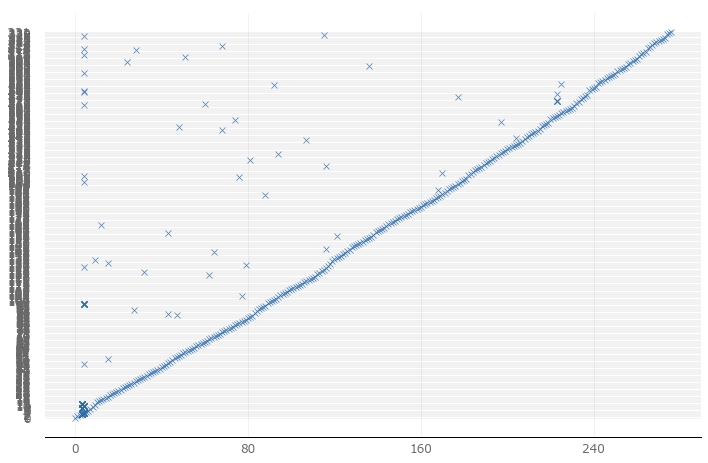

In [50]:
r.plot_regs()

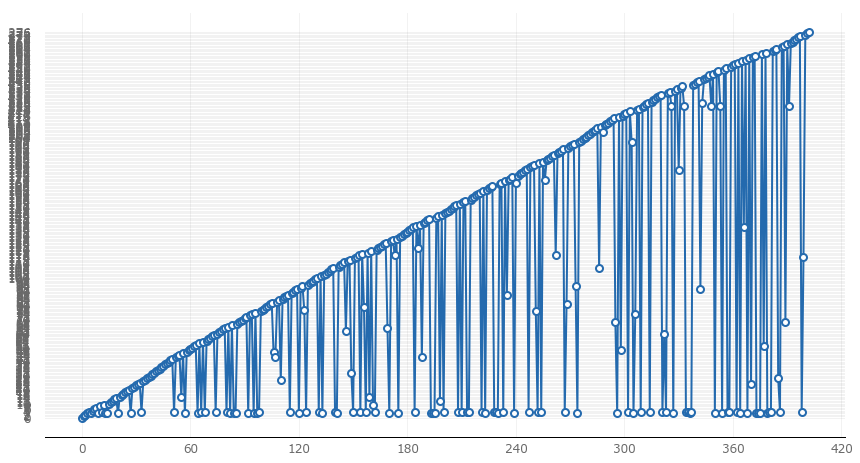

In [51]:
r.plot_line()

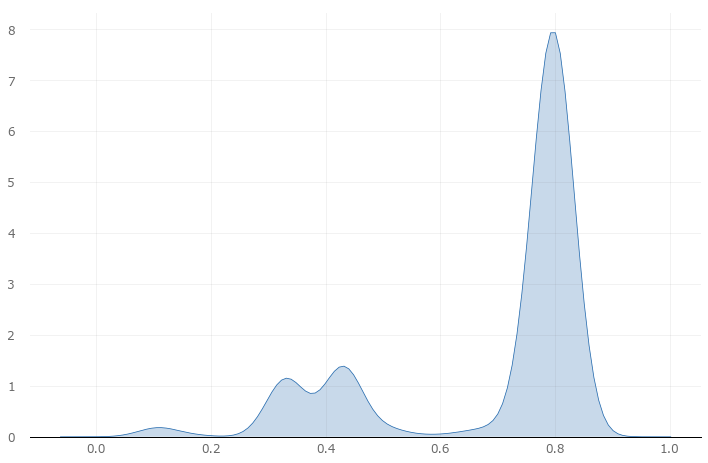

In [52]:
r.plot_kde('val_acc')

In [65]:
# this is the size of our encoded representations# this i 
input_dim = train.shape[1]
print(input_dim)

input_img = Input(shape=(input_dim,))
x = Dense(100, activation='elu', kernel_initializer='normal')(input_img)
x = Dense(60, activation='elu', kernel_initializer='normal')(x)
x = Dense(30, activation='elu', kernel_initializer='normal')(x)
y = Dense(15, activation='elu', kernel_initializer='normal')(x)
decoded = Dense(30, activation='elu', kernel_initializer='normal')(y)
decoded = Dense(60, activation='elu', kernel_initializer='normal')(decoded)
decoded = Dense(100, activation='elu', kernel_initializer='normal')(decoded)
z = Dense(input_dim, activation='sigmoid', kernel_initializer='normal')(decoded)
autoencoder = Model(input_img, z)
autoencoder.summary()

122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 122)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               12300     
_________________________________________________________________
dense_42 (Dense)             (None, 60)                6060      
_________________________________________________________________
dense_43 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_44 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_45 (Dense)             (None, 30)                480       
_________________________________________________________________
dense_46 (Dense)             (None, 60)                1860      
______

In [66]:

##loading autoencoder untuk data tes
# load weights
autoencoder.load_weights("./log3/taloslr_weights_a.best.hdf5")
# Compile model (required to make predictions)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
scores = autoencoder.evaluate(test, test, verbose=0)
print("%s: %.2f%%" % (autoencoder.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
acc: 93.57%


In [68]:
# this is the size of our encoded representations# this i 
input_dim = train.shape[1]
print(input_dim)

input_img = Input(shape=(input_dim,))
x = Dense(100, activation='elu', kernel_initializer='normal')(input_img)
x = Dense(50, activation='elu', kernel_initializer='normal')(x)
x = Dense(30, activation='elu', kernel_initializer='normal')(x)
y = Dense(20, activation='elu', kernel_initializer='normal')(x)
decoded = Dense(30, activation='elu', kernel_initializer='normal')(y)
decoded = Dense(50, activation='elu', kernel_initializer='normal')(decoded)
decoded = Dense(100, activation='elu', kernel_initializer='normal')(decoded)
z = Dense(input_dim, activation='sigmoid', kernel_initializer='normal')(decoded)
autoencoder = Model(input_img, z)
autoencoder.summary()


num_classes=5
#encoder is the model of the autoencoder slice in the middle 
encoder = Model(input_img, y)
# define new model encoder->Dense  10 neurons with soft max for classification 
out2 = Dense(num_classes, activation='softmax', kernel_initializer='normal')(encoder.output)
newmodel = Model(encoder.input,out2)
newmodel.summary()

122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 122)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)               12300     
_________________________________________________________________
dense_50 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_51 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_52 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_53 (Dense)             (None, 30)                630       
_________________________________________________________________
dense_54 (Dense)             (None, 50)                1550      
______

In [69]:
##loading autoencoder untuk data tes
# load weights
newmodel.load_weights("./log3/taloslr_weights_2a.best.hdf5")
# Compile model (required to make predictions)
newmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
scores = newmodel.evaluate(test, y_test, verbose=0)
print("%s: %.2f%%" % (newmodel.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
acc: 83.25%


In [70]:
preds = newmodel.predict(test)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(y_test, axis=1)
# With the confusion matrix, we can aggregate model predictions
# This helps to understand the mistakes and refine the model

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_lbls, pred_lbls)

array([[6370,  868,  210,   10,    0],
       [  72, 9418,  212,    4,    5],
       [ 164,  258, 1999,    0,    0],
       [   0, 1774,   10,  966,    4],
       [   3,  156,   16,   11,   14]], dtype=int64)

In [72]:
from sklearn.metrics import classification_report
outcomes = ['DoS', 'normal' ,'Probe' ,'U2R','R2L' ]
class_names=outcomes

target_names = ["Class {}".format(i) for i in range(5)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

         DoS    0.96384   0.85412   0.90567      7458
      normal    0.75501   0.96983   0.84904      9711
       Probe    0.81692   0.82569   0.82128      2421
         U2R    0.97477   0.35076   0.51589      2754
         R2L    0.60870   0.07000   0.12556       200

    accuracy                        0.83246     22544
   macro avg    0.82385   0.61408   0.64349     22544
weighted avg    0.85629   0.83246   0.81768     22544



In [73]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=None)

Confusion matrix, without normalization
[[6370  868  210   10    0]
 [  72 9418  212    4    5]
 [ 164  258 1999    0    0]
 [   0 1774   10  966    4]
 [   3  156   16   11   14]]


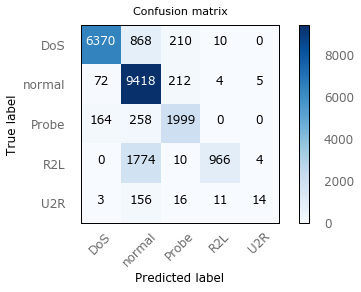

In [74]:
outcomes = ['DoS', 'normal','Probe' ,'R2L', 'U2R']
class_names=outcomes


results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))